# OCT simulations with Python

This notebook describes basic OCT signal processing steps and visualizes them. The work is mostly based on the work presented in

_J. Kalkman, Fourier-Domain Optical Coherence Tomography Signal Analysis and Numerical Modeling, International Journal of Optics 2017_

In [3]:
# basic functions
import numpy as np
import matplotlib.pyplot as plt

# for enabling interaction with the plots
from ipywidgets import interact, interactive, fixed, interact_manual

### Basic Fourier-domain OCT simulation

We consider a Fourier domain OCT system. The signal is acquired in the $k$-domain and Fourier transformed to the $z$-domain.

In [6]:
# OCT parameters
lambdac=950         # center wavelength [nm]
dlambda=150         # bandwidth [nm]
P0=1                # input power [mW]
tau=1e-6            # integration time [s]
N=1024              # number of pixels
alpha=0.5           # intensity splitting ratio

kc=2*np.pi/(lambdac*1e-9)
dk=1e9*dlambda*2*np.pi/lambdac**2             # FWHM_k
kmin=kc-2*dk                        # 2*dk is necessary to avoid problems in the z-domain
kmax=kc+2*dk

k=np.linspace(kmin,kmax,N)
deltak=k[1]-k[0]
n0=np.linspace(0, N-1, N)       # pixel axis
z=np.linspace(-0.5*np.pi/deltak, 0.5*np.pi/deltak, N)
deltaz=z[2]-z[1]

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.interpolate

def makeplot(P0, dlambda, zmir, chirp):
    # P0 in mW
    # dlambda in nm
    # zmir in mm 

    dk=1e9*dlambda*2*np.pi/lambdac**2
    sigmak = dk/(2*np.sqrt(2*np.log(2))) 

    chirp*=1e-7*chirp
    kchirp=k[0]+(1-chirp*(N-1)*deltak)*n0*deltak+chirp*n0**2*deltak**2
            
    # Calculation of the OCT signal
    Sks=(P0*1e-3)/(np.sqrt(2*np.pi*sigmak**2))*np.exp(-(k-kc)**2/(2*sigmak**2))

    Ukref=np.sqrt(alpha*(1-alpha))*np.sqrt(Sks)
    Uksam=np.sqrt(alpha*(1-alpha))*np.sqrt(Sks)*np.exp(1j*2*k*zmir*1e-3)
    Uksamchirp=np.sqrt(alpha*(1-alpha))*np.sqrt(Sks)*np.exp(1j*2*kchirp*zmir*1e-3)
    Ikint=np.real(Uksam+Ukref*np.conj(Uksam+Ukref))-np.real(Ukref*np.conj(Ukref))-np.real(Uksam*np.conj(Uksam))
    Ikintchirp=np.real(Uksamchirp+Ukref*np.conj(Uksamchirp+Ukref))-np.real(Ukref*np.conj(Ukref))-np.real(Uksam*np.conj(Uksamchirp))
    
    fig, axes = plt.subplots(1,3)
    plt.figure(fig).set_figwidth(15)
    plt.subplot(131)
    axes[0].plot(k, Ikint, '-.b', label='ideal OCT signal')
    axes[0].plot(k, Ikintchirp, '-.r', label='chirped OCT signal')
    plt.title('OCT spectrum')
    plt.xlabel('Wavenumber (rad/m)')
    plt.ylabel('Intensity (arb. units)')
    plt.grid(), plt.legend(fontsize="6")

    plt.subplot(132)
    plt.plot(k, k, '-b', label='lineak k')
    plt.plot(k, kchirp, '-r', label='chirped k')
    plt.title('OCT spectral phase')
    plt.xlabel('Wavenumber (rad/m)')
    plt.ylabel('Phase (rad)')
    plt.grid(), plt.legend(fontsize="6")

    iz=np.fft.fftshift(np.fft.ifft(Ikint))
    izchirp=np.fft.fftshift(np.fft.ifft(Ikintchirp))
    #f = scipy.interpolate.interp1d(kchirp, Ikintchirp, kind='cubic')
    ##klin=np.linspace(np.amin(kchirp), np.amax(kchirp), N)
    #Ikintcorr = f(klin)
    #izdechirp=np.fft.fftshift(np.fft.ifft(Ikintcorr))

    plt.subplot(133) 
    axes[2].plot(1e3*z, np.abs(iz)**2, '-b', label='ideal OCT signal')
    axes[2].plot(1e3*z, np.abs(izchirp)**2, '--r', label='chirped OCT signal')
    plt.title('OCT scan')
    plt.xlabel('Depth (mm)')
    plt.ylabel('OCT intensity (arb. units)')
    plt.grid(), plt.legend(fontsize="6")

    # switch between +z and -z
    peakpos=int(1e-3*zmir/deltaz)+int(N/2)
    zrange=10
        
    ins = inset_axes(axes[2], width="30%", height=2.0, loc=1)
    plt.plot(1e3*z[int(peakpos-zrange):int(peakpos+zrange)], np.abs(iz[int(peakpos-zrange):int(peakpos+zrange)])**2, '-b', label='ideal OCT signal')
    plt.plot(1e3*z[int(peakpos-zrange):int(peakpos+zrange)], np.abs(izchirp[int(peakpos-zrange):int(peakpos+zrange)])**2, '--r', label='chirped OCT signal')
    plt.grid()

    plt.tight_layout()
    plt.show()

interactive(makeplot, P0=(0, 5, 0.1), dlambda=(0, 400,10), zmir=(1e3*np.min(z), 1e3*np.max(z), 0.1), chirp=(0,1,0.1))

interactive(children=(FloatSlider(value=2.0, description='P0', max=5.0), IntSlider(value=200, description='dla…

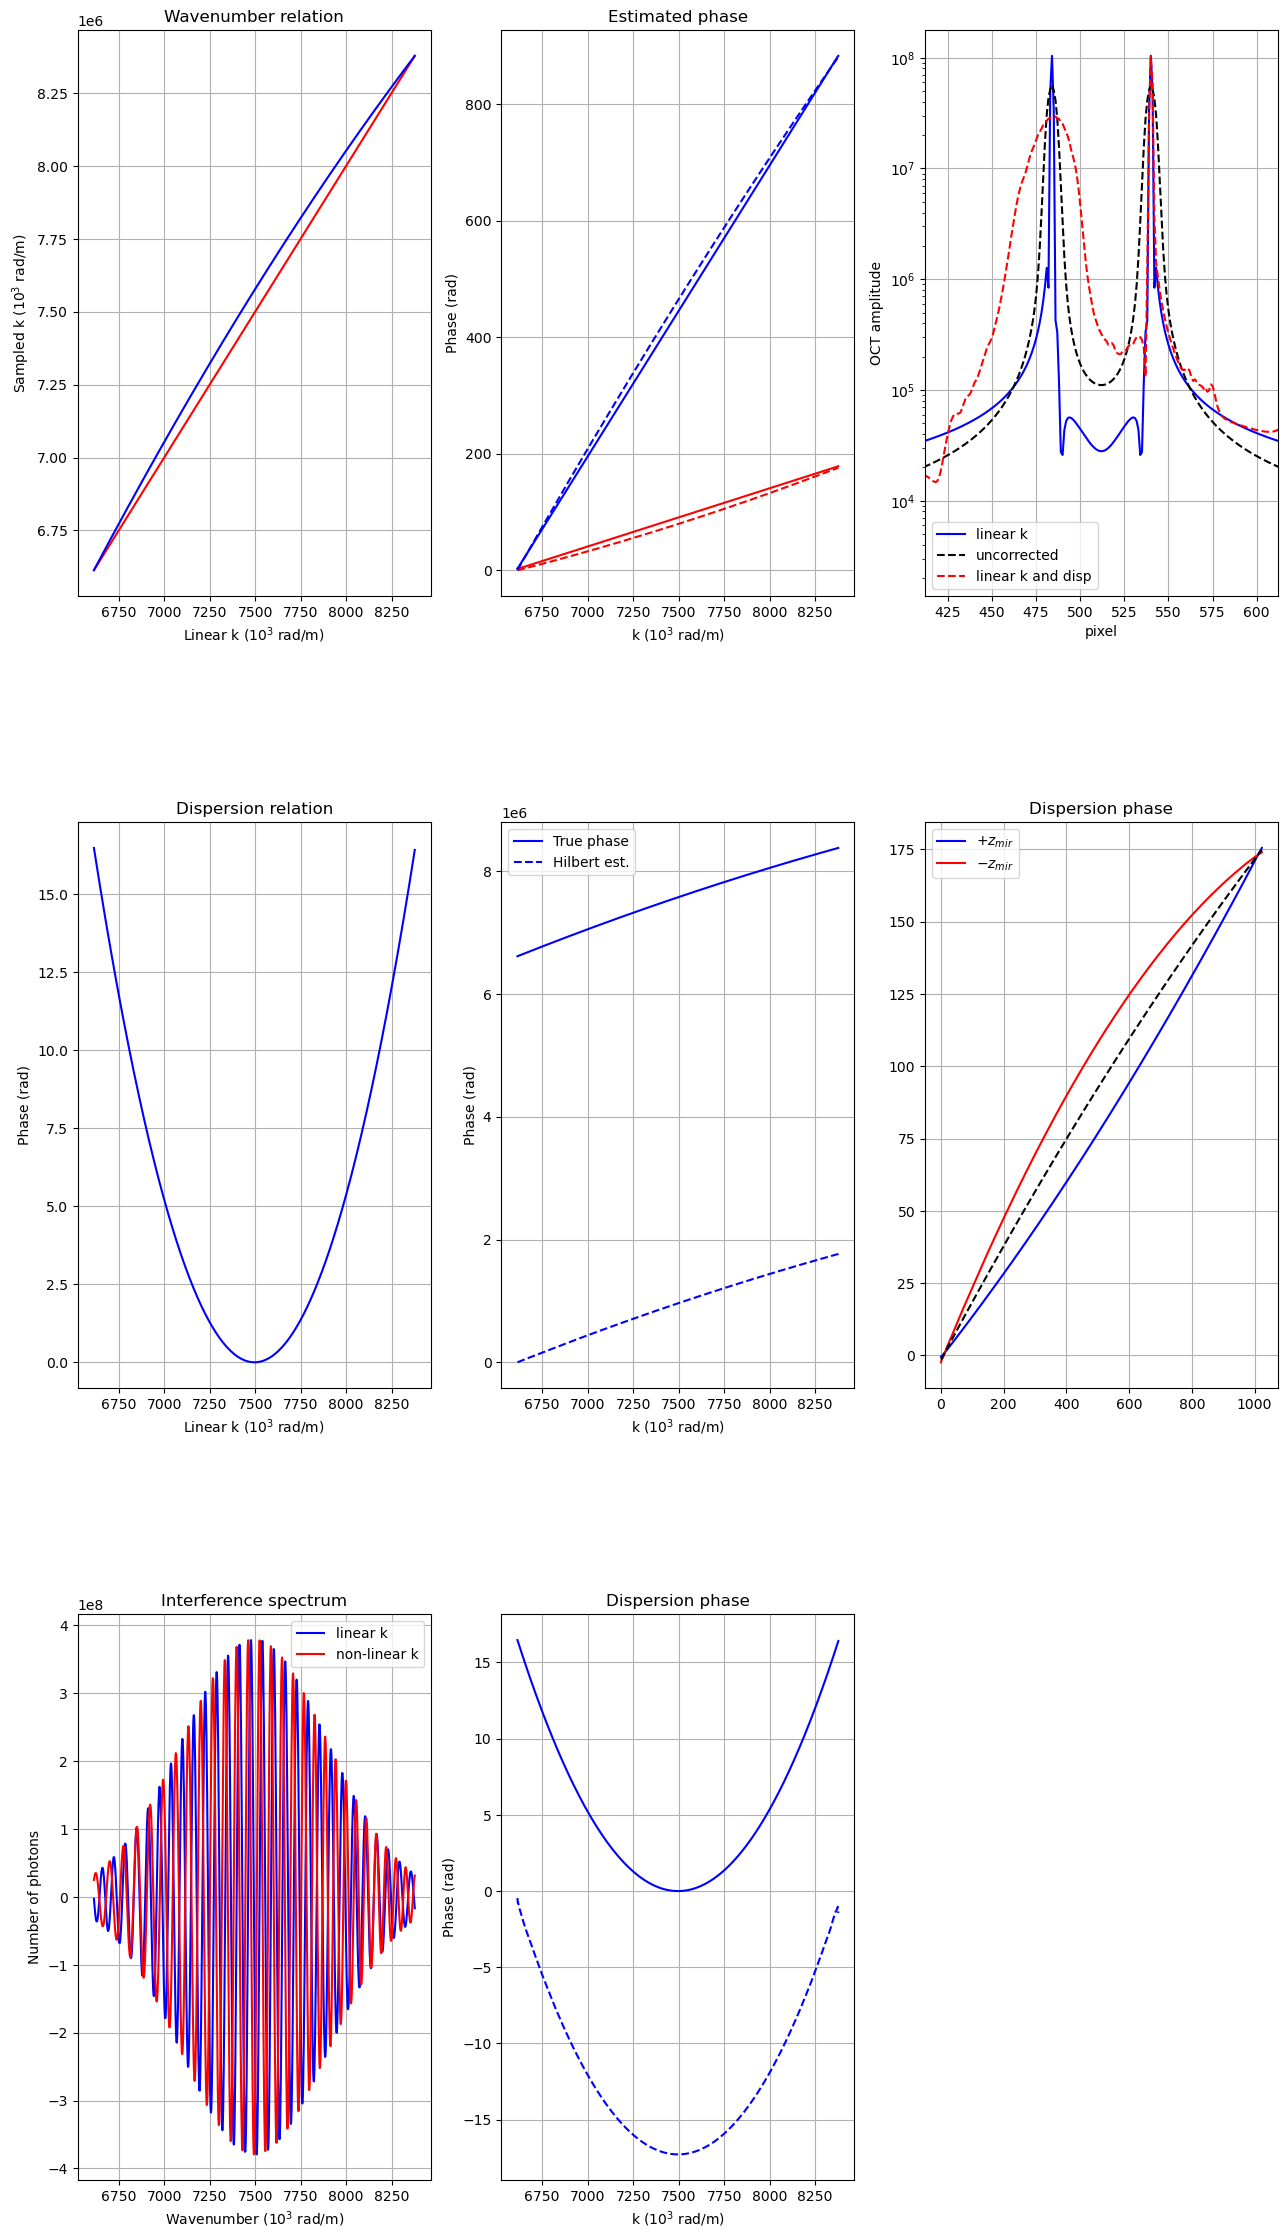

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate
import scipy.signal

plt.close('all')

plt.figure(num=1, figsize=(15,25))
plt.figure(1).subplots_adjust(left=0.15, bottom=0.12, right=0.95, top=0.98, hspace=0.4)

# physical parameters of OCT system
lambdac=850e-9                 # center wavelength [m]
dlambda=50e-9                # FWHM width of the source [m]
P0=1e-3                        # source power [W]
tau=1e-3                       # integration time [s]
alpha=0.5
M=1024                         # number of samples

# Calculate number of photons from P0 tau/hv
vuc=3e8/lambdac
Ntot=P0*tau/(6.6e-34*vuc)

# Parameters ofobject and reference 
rr=1e-0                 # amplitude reflection coefficient reference
rs=1e-1                 # amplitude reflection coefficient sample


# Define linear and chirped k
# beta=0 is linear, any other beta generates a non-linearity 
m0=np.linspace(0, M-1, M)       # pixel axis
klin=np.linspace(2*np.pi/(lambdac+2*dlambda), 2*np.pi/(lambdac-2*dlambda), M)
deltak=klin[1]-klin[0]
beta=-1e-7
kchirp=klin[0]+(1-beta*(M-1)*deltak)*m0*deltak+beta*m0**2*deltak**2

# linear term
# gamma=1e-2
# phik=gamma*2*np.pi*(m0-M/2)
# quadratic term
gamma=1e-5
phik=gamma*2*np.pi*(m0-M/2)**2

plt.subplot(331)
plt.plot(klin/1e3, klin, '-r', label='linear k')
plt.plot(klin/1e3, kchirp, '-b', label='linear k')
plt.title('Wavenumber relation')
plt.xlabel('Linear k (10$^3$ rad/m)')
plt.ylabel('Sampled k (10$^3$ rad/m)')
plt.grid()

plt.subplot(334)
plt.plot(klin/1e3, phik, '-b', label='linear k')
plt.title('Dispersion relation')
plt.xlabel('Linear k (10$^3$ rad/m)')
plt.ylabel('Phase (rad)')
plt.grid()

kc=(klin[M-1]+klin[0])/2
sigma=4e5
Sk=(Ntot/np.sqrt(2*np.pi*sigma**2))*np.exp(-(klin-kc)**2/2/sigma**2)/np.sum((1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(klin-kc)**2/2/sigma**2) )
#check=sum(Sk)
#print(check)
## normalization oke for Gauss in boxcar due to second normalization factor

zmir=50e-6                     
Ekref=rr*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))
Eksam=rs*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))*np.exp(1j*2*klin*zmir)
ik1lin=np.real((Eksam+Ekref)*np.conj(Eksam+Ekref))-alpha*(1-alpha)*Sk*rr**2-alpha*(1-alpha)*Sk*rs**2

zmir=250e-6                     
Eksam=rs*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))*np.exp(1j*2*klin*zmir)
ik2lin=np.real((Eksam+Ekref)*np.conj(Eksam+Ekref))-alpha*(1-alpha)*Sk*rr**2-alpha*(1-alpha)*Sk*rs**2

plt.subplot(337)
plt.plot(klin/1e3, ik1lin, '-b', label='linear k')
plt.title('Interference spectrum')
plt.xlabel('Wavenumber (10$^3$ rad/m)')
plt.ylabel('Number of photons')
plt.grid()
        
ik1ana=scipy.signal.hilbert(ik1lin)
phaseik1ana=np.unwrap(np.angle(ik1ana))
ik2ana=scipy.signal.hilbert(ik2lin)
phaseik2ana=np.unwrap(np.angle(ik2ana))

plt.subplot(332)
plt.plot(klin/1e3, phaseik1ana, '-r')
plt.plot(klin/1e3, phaseik2ana, '-b')

zmir1=50e-6                     
Ekref=rr*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))
Eksam=rs*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))*np.exp(1j*(2*kchirp*zmir1 + phik))
ik1=np.real((Eksam+Ekref)*np.conj(Eksam+Ekref))-alpha*(1-alpha)*Sk*rr**2-alpha*(1-alpha)*Sk*rs**2

zmir2=250e-6                     
Ekref=rr*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))
Eksam=rs*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))*np.exp(1j*(2*kchirp*zmir2 + phik))
ik2=np.real((Eksam+Ekref)*np.conj(Eksam+Ekref))-alpha*(1-alpha)*Sk*rr**2-alpha*(1-alpha)*Sk*rs**2

plt.subplot(337)
plt.plot(klin/1e3, ik1, '-r', label='non-linear k')
plt.legend()

ik1ana=scipy.signal.hilbert(ik1)
phaseik1ana=np.unwrap(np.angle(ik1ana))
ik2ana=scipy.signal.hilbert(ik2)
phaseik2ana=np.unwrap(np.angle(ik2ana))

plt.subplot(332)
plt.plot(klin/1e3, phaseik1ana, '--r')
plt.plot(klin/1e3, phaseik2ana, '--b')
plt.title('Estimated phase')
plt.xlabel('k (10$^3$ rad/m)')
plt.ylabel('Phase (rad)')
plt.grid()
        
plt.subplot(335)
kchirpest=0.5*(phaseik1ana-phaseik2ana)/(zmir1-zmir2)
plt.plot(klin/1e3, kchirp, '-b', label='True phase')
plt.plot(klin/1e3, kchirpest, '--b', label='Hilbert est.')
plt.xlabel('k (10$^3$ rad/m)')
plt.ylabel('Phase (rad)')
plt.legend()
plt.grid()

phikest=phaseik1ana-2*kchirpest*zmir1
# offset in phase is removed
plt.subplot(338)
plt.title('Dispersion phase')
plt.plot(klin/1e3, phik, '-b', label='input dispersion')
plt.plot(klin/1e3, phikest, '--b', label='known $z_{mir}$')
plt.xlabel('k (10$^3$ rad/m)')
plt.ylabel('Phase (rad)')
plt.grid()

iz1lin=np.fft.fftshift(np.fft.ifft(ik1lin))
iz1=np.fft.fftshift(np.fft.ifft(ik1))
iz2lin=np.fft.fftshift(np.fft.ifft(ik2lin))
iz2=np.fft.fftshift(np.fft.ifft(ik2))
plt.subplot(333)
plt.semilogy(np.abs(iz1lin), '-b', label='linear k')
plt.semilogy(np.abs(iz1), '--k', label='uncorrected')
plt.xlim([M/2 -100, M/2 + 100])
plt.grid()

# and now implement the chirp correction

#phaselin=np.linspace(np.amin(kchirpest), np.amax(kchirpest), M)
#f = sp.interpolate.interp1d(kchirpest, ik1, kind='cubic')
#ik1corr = f(phaselin)
#
#iz1corr=np.fft.fftshift(np.fft.ifft(ik1corr))
#plt.semilogy(np.abs(iz1corr), '-k', label='dechirped')
#plt.legend()          
       
Eksam=rs*np.sqrt(Sk)*np.sqrt(alpha*(1-alpha))*np.exp(1j*(-2*kchirp*zmir1 + phik))
ik1neg=np.real((Eksam+Ekref)*np.conj(Eksam+Ekref))-alpha*(1-alpha)*Sk*rr**2-alpha*(1-alpha)*Sk*rs**2

ik1ana=scipy.signal.hilbert(ik1)
phaseik1=np.unwrap(np.angle(ik1ana))
ik1ana=scipy.signal.hilbert(ik1neg)
phaseik1neg=np.unwrap(np.angle(ik1ana))
meanphase=(phaseik1+phaseik1neg)/2

plt.subplot(336)
plt.title('Dispersion phase')
plt.plot(phaseik1, '-b', label='$+z_{mir}$')
plt.plot(phaseik1neg, '-r', label='$-z_{mir}$')
plt.plot(meanphase, '--k')
plt.legend()
plt.grid()

phidispest=(phaseik1-phaseik1neg)/2


plt.subplot(338)
#plt.plot(klin/1e3, phidispestcorr, '-r', label='+/- delay')
##plt.ylim([-10,50])
#plt.grid()
#plt.legend()

plt.subplot(333)
ik1corr1=ik1*np.exp(1j*phidispest)
phaselin=np.linspace(np.amin(kchirpest), np.amax(kchirpest), M)
f = sp.interpolate.interp1d(kchirpest, ik1corr1, kind='cubic')
ik1corr2 = f(phaselin)
izcorr=np.fft.fftshift(np.fft.ifft(ik1corr2))
plt.semilogy(np.abs(izcorr), '--r', label='linear k and disp')
plt.xlabel('pixel')
plt.ylabel('OCT amplitude')
plt.legend(loc=3)